## Converting  grayscale to colored images (RGB) using Autoencoder

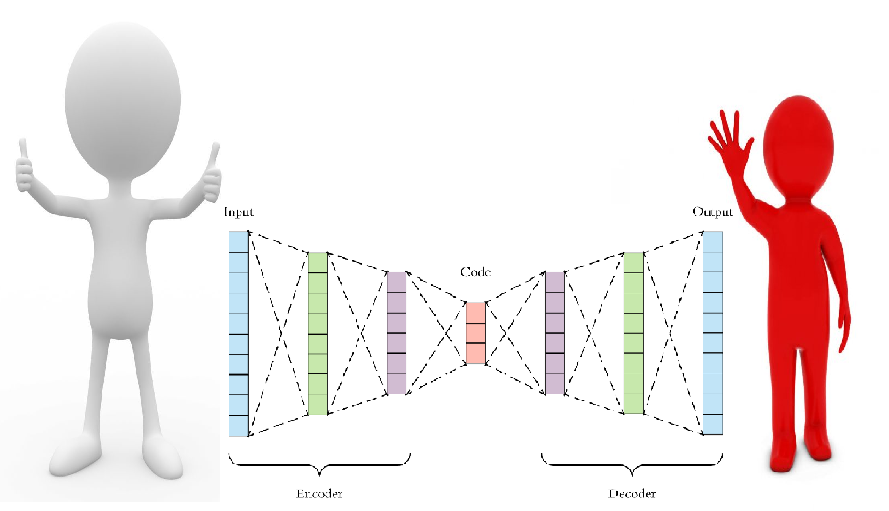

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrvmurali","key":"b52d02bd18b2eed468ba2144e5ad2c6b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

100% 192M/192M [00:02<00:00, 66.5MB/s]



In [4]:
!unzip "landscape-image-colorization.zip"

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [5]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [6]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [7]:
SIZE = 160
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))

 83%|████████▎ | 5929/7129 [00:05<00:01, 1082.77it/s]


In [8]:
gray_img = []
path ='/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 84%|████████▎ | 5954/7129 [00:04<00:00, 1336.84it/s]


In [9]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

In [31]:
color_img[1]

array([[[0.07843138, 0.11764706, 0.16470589],
        [0.827451  , 0.8784314 , 0.92156863],
        [0.78431374, 0.8392157 , 0.94509804],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.12941177, 0.16470589, 0.21960784],
        [0.8235294 , 0.87058824, 0.9254902 ],
        [0.7490196 , 0.8156863 , 0.91764706],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.16078432, 0.20392157, 0.26666668],
        [0.8509804 , 0.90588236, 0.92941177],
        [0.7764706 , 0.8509804 , 0.9372549 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.7372549 , 0.61960787, 0.11372549],
        [0.7647059 , 0.6509804 , 0.14117648],
        [0.7647059 , 0

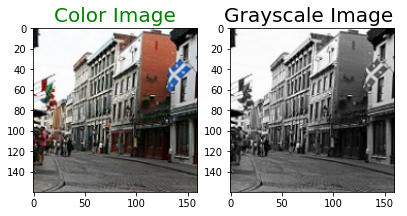

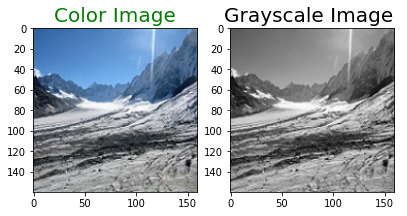

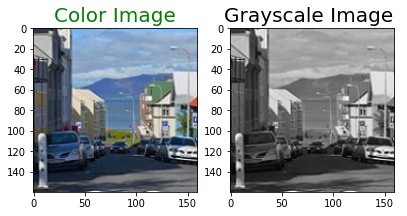

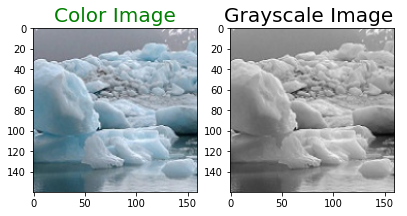

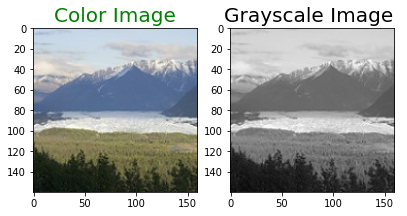

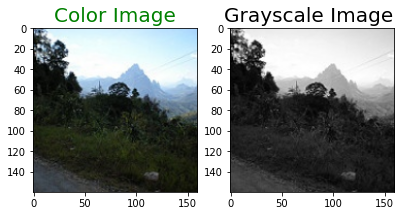

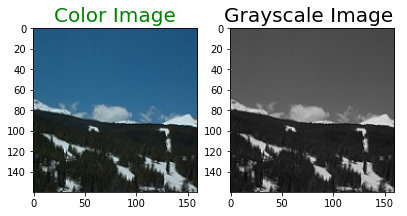

In [10]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [11]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]

In [12]:
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)

Train color image shape: (5500, 160, 160, 3)


In [13]:
test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Test color image shape (500, 160, 160, 3)


In [46]:
test_gray_image[1].shape

(160, 160, 3)

In [14]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [15]:
def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [16]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [17]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 9,602,766
Trainable params: 9,600,206
Non-trainable params: 2,560
__________________________________________________________________________________________________


In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [19]:
model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 1,validation_data=(test_gray_image,test_color_image))

Epoch 1/50
110/110 [==============================] - 64s 269ms/step - loss: 0.0918 - acc: 0.3519 - val_loss: 0.0687 - val_acc: 0.4416
Epoch 2/50
110/110 [==============================] - 30s 273ms/step - loss: 0.0658 - acc: 0.3932 - val_loss: 0.0634 - val_acc: 0.4290
Epoch 3/50
110/110 [==============================] - 29s 266ms/step - loss: 0.0591 - acc: 0.4263 - val_loss: 0.0600 - val_acc: 0.3841
Epoch 4/50
110/110 [==============================] - 29s 268ms/step - loss: 0.0565 - acc: 0.4350 - val_loss: 0.0551 - val_acc: 0.4401
Epoch 5/50
110/110 [==============================] - 30s 271ms/step - loss: 0.0520 - acc: 0.4676 - val_loss: 0.0530 - val_acc: 0.4624
Epoch 6/50
110/110 [==============================] - 29s 266ms/step - loss: 0.0495 - acc: 0.4844 - val_loss: 0.0510 - val_acc: 0.4852
Epoch 7/50
110/110 [==============================] - 29s 268ms/step - loss: 0.0486 - acc: 0.4873 - val_loss: 0.0490 - val_acc: 0.5144
Epoch 8/50
110/110 [==============================] - 2

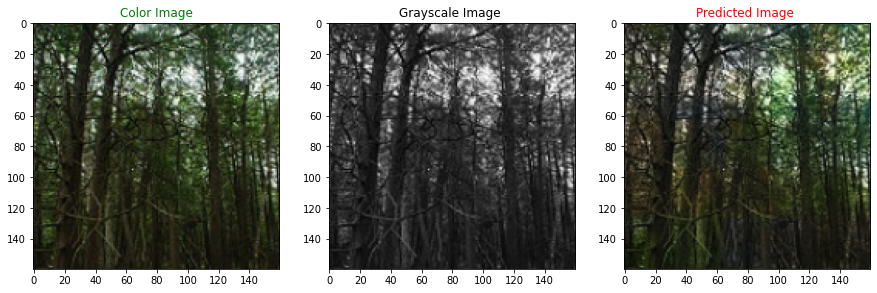

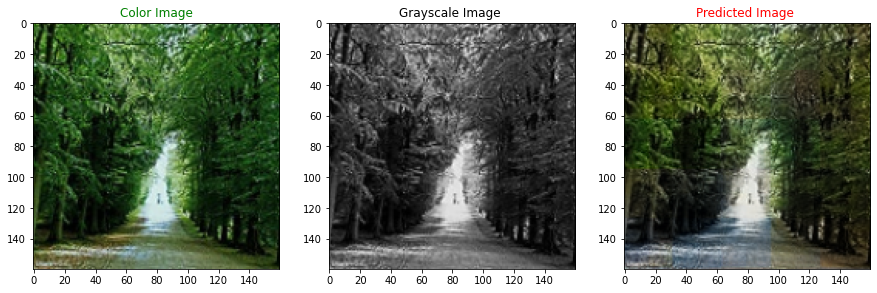

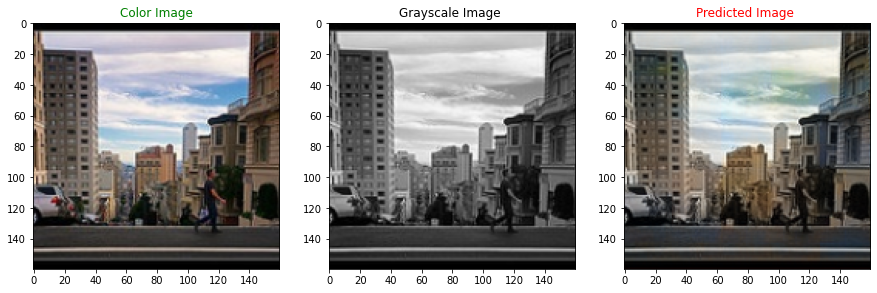

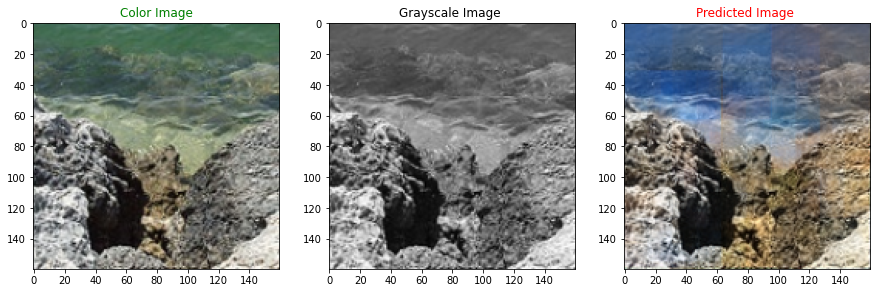

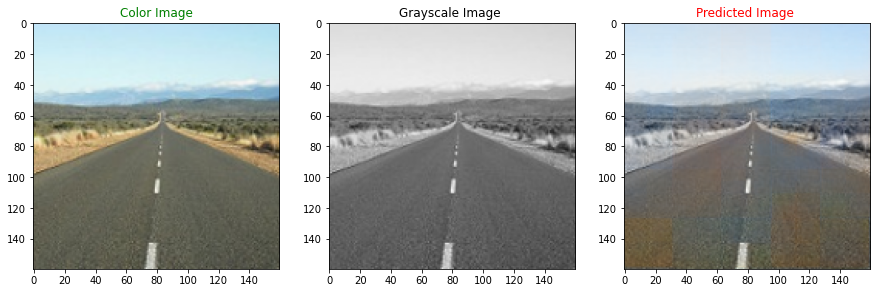

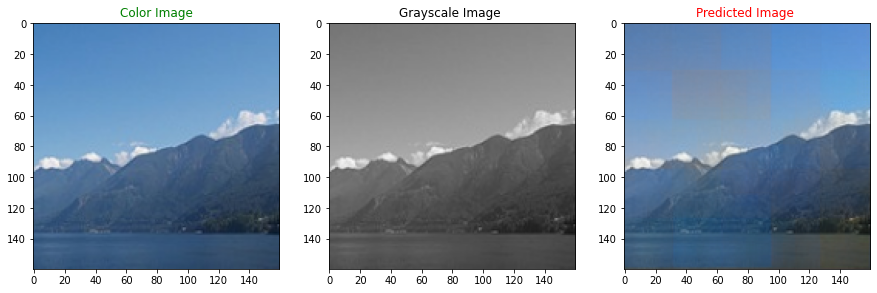

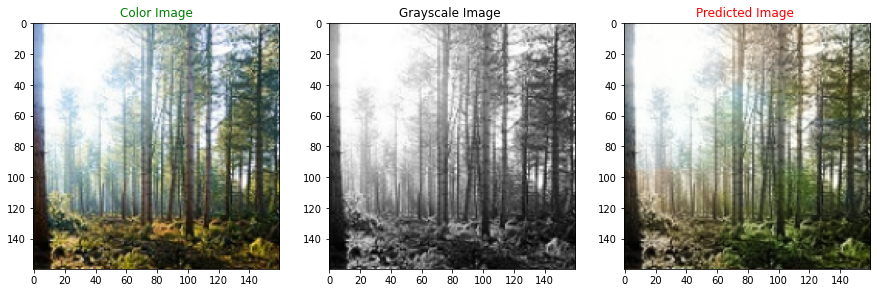

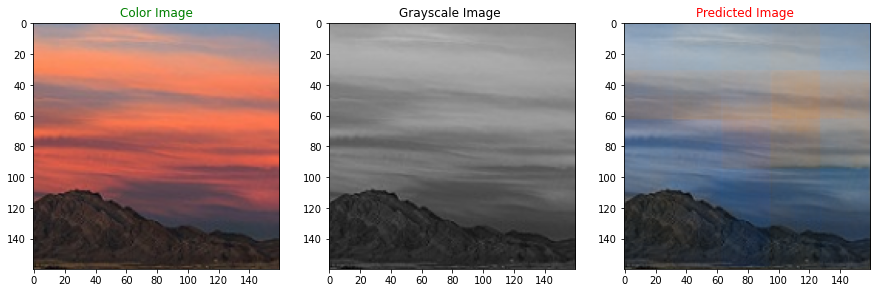

In [20]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 12)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 12)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 12)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [76]:
# defining function to plot images pair
def plot_image(grayscale,predicted):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Grayscale Image ', color = 'black', fontsize = 12)
    plt.imshow(grayscale)
    plt.subplot(1,2,2)
    plt.title('Predicted Image ', color = 'Red', fontsize = 12)
    plt.imshow(predicted)
   
    plt.show()

In [77]:
from tensorflow.keras.preprocessing import image
def pred(path):
  test_image = image.load_img(path, target_size = (SIZE,SIZE))
  test_image=np.array(test_image)
  test_image=test_image/255
  #test_image = np.reshape(test_image,(1,SIZE,SIZE,3))
  predicted = np.clip(model.predict(test_image.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
  plot_image(test_image,predicted)
   

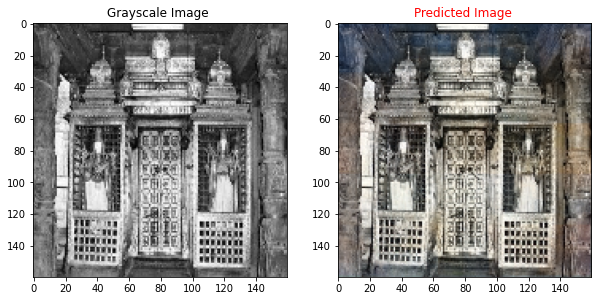

In [79]:
pred("/content/main-qimg-917ee7f76eea02ac36c1bd4ddc6263c5-c.jpg")